In [1]:
import math
import pandas as pd
import numpy as np
from operator import itemgetter


import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

from sklearn import tree
from sklearn.tree import _tree

from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import RandomForestClassifier 

from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import warnings
warnings.filterwarnings("ignore")


sns.set()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

INFILE = "C:\\Users\\Owner\\Documents\\Northwestern\\Intro_MachineLearning\\Unit1\\Lecture02B_MissingValueImputationForNumericVariables\\Insurance.csv"

TARGET_F = "TARGET_CLM_FLAG"
TARGET_A = "TARGET_CLM_AMT"

df = pd.read_csv( INFILE )

dt = df.dtypes
#print( dt )

objList = []
numList = []
for i in dt.index :
    #print(" here is i .....", i , " ..... and here is the type", dt[i] )
    if i in ( [ TARGET_F, TARGET_A ] ) : continue
    if dt[i] in (["object"]) : objList.append( i )
    if dt[i] in (["float64","int64"]) : numList.append( i )

In [2]:
"""
FILL IN MISSING WITH THE CATEGORY "MISSING"
"""
for i in objList :
    if df[i].isna().sum() == 0 : continue
    NAME = "IMP_"+i
    df[NAME] = df[i]
    df[NAME] = df[NAME].fillna("MISSING")
    g = df.groupby( NAME )
    df = df.drop( i, axis=1 )

dt = df.dtypes
objList = []
for i in dt.index :
    #print(" here is i .....", i , " ..... and here is the type", dt[i] )
    if i in ( [ TARGET_F, TARGET_A ] ) : continue
    if dt[i] in (["object"]) : objList.append( i )

In [3]:
'''
EXPLORE THE CATEGORICAL / OBJECT VARIABLES
'''
df["y_EDU_4"] = (df.EDUCATION.isin( ["a_PhD"] ) + 0 )
df["y_EDU_3"] = (df.EDUCATION.isin( ["a_PhD","b_Masters"] ) + 0)
df["y_EDU_2"] = (df.EDUCATION.isin( ["a_PhD","b_Masters","c_Bachelors"] ) + 0)
df["y_EDU_1"] = (df.EDUCATION.isin( ["a_PhD","b_Masters","c_Bachelors","d_High School"] ) + 0)
df = df.drop( "EDUCATION", axis=1 )
   

dt = df.dtypes
objList = []
for i in dt.index :
    #print(" here is i .....", i , " ..... and here is the type", dt[i] )
    if i in ( [ TARGET_F, TARGET_A ] ) : continue
    if dt[i] in (["object"]) : objList.append( i )


for i in objList :
    thePrefix = "z_" + i
    y = pd.get_dummies( df[i], prefix=thePrefix, drop_first=True )   
    #y = pd.get_dummies( df[i], prefix=thePrefix )   
    df = pd.concat( [df, y], axis=1 )
    #df = df.drop( i, axis=1 )


i = "INCOME"
FLAG = "M_" + i
IMP = "IMP_" + i
#print( i )
#print( FLAG )
#print( IMP )
df[ FLAG ] = df[i].isna() + 0
df[ IMP ] = df[ i ]
df.loc[ df[IMP].isna() & df["IMP_JOB"].isin(["Blue Collar"]), IMP ] = 53694
df.loc[ df[IMP].isna() & df["IMP_JOB"].isin(["Student"]), IMP ] = 360
df.loc[ df[IMP].isna() & df["IMP_JOB"].isin(["Clerical"]), IMP ] = 30799
df.loc[ df[IMP].isna() & df["IMP_JOB"].isin(["Doctor"]), IMP ] = 121398
df.loc[ df[IMP].isna() & df["IMP_JOB"].isin(["Home Maker"]), IMP ] = 776
df.loc[ df[IMP].isna() & df["IMP_JOB"].isin(["Lawyer"]), IMP ] = 83230
df.loc[ df[IMP].isna() & df["IMP_JOB"].isin(["MISSING"]), IMP ] = 109953
df.loc[ df[IMP].isna() & df["IMP_JOB"].isin(["Manager"]), IMP ] = 78589
df.loc[ df[IMP].isna() & df["IMP_JOB"].isin(["Professional"]), IMP ] = 71230
df.loc[ df[IMP].isna(), IMP ] = df[i].median()
df = df.drop( i, axis=1 )
numList.remove(i)


for i in numList :
    if df[i].isna().sum() == 0 : continue
    FLAG = "M_" + i
    IMP = "IMP_" + i
    #print(i)
    #print( df[i].isna().sum() )
    #print( FLAG )
    #print( IMP )
    #print(" ------- ")
    df[ FLAG ] = df[i].isna() + 0
    df[ IMP ] = df[ i ]
    df.loc[ df[IMP].isna(), IMP ] = df[i].median()
    df = df.drop( i, axis=1 )

In [4]:
"""
Remove Outliers
"""
dt = df.dtypes
numList = []
for i in dt.index :
    #print(i, dt[i])
    if i in ( [ TARGET_F, TARGET_A ] ) : continue
    if dt[i] in (["float64","int64"]) : numList.append( i )

for i in numList :
    theMean = df[i].mean()
    theSD = df[i].std()
    theMax = df[i].max()
    theCutoff = round( theMean + 3*theSD )
    if theMax < theCutoff : continue
    FLAG = "O_" + i
    TRUNC = "TRUNC_" + i
    df[ FLAG ] = ( df[i] > theCutoff )+ 0
    df[ TRUNC ] = df[ i ]
    df.loc[ df[TRUNC] > theCutoff, TRUNC ] = theCutoff
    df = df.drop( i, axis=1 )

for i in objList:
    df = df.drop( i, axis=1 )

In [5]:
"""
SPLIT DATA
"""

X = df.copy()
X = X.drop( TARGET_F, axis=1 )
X = X.drop( TARGET_A, axis=1 )

Y = df[ [TARGET_F, TARGET_A] ]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=2)
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2 )

##print( "FLAG DATA" )
##print( "TRAINING = ", X_train.shape )
##print( "TEST = ", X_test.shape )


F = ~ Y_train[ TARGET_A ].isna()
W_train = X_train[F].copy()
Z_train = Y_train[F].copy()

F = ~ Y_test[ TARGET_A ].isna()
W_test = X_test[F].copy()
Z_test = Y_test[F].copy()

#print( Z_train.describe() )
#print( Z_test.describe() )
#print( "\n\n")

F = Z_train[ TARGET_A ] > 25000
Z_train.loc[ F, TARGET_A ] = 25000

F = Z_test[ TARGET_A ] > 25000
Z_test.loc[ F, [TARGET_A] ] = 25000

#print( Z_train.describe() )
#print( Z_test.describe() )
#print( "\n\n")


##print( " ====== ")
##
##print( "AMOUNT DATA" )
##print( "TRAINING = ", W_train.shape )
##print( "TEST = ", Z_test.shape )

In [6]:
"""
MODEL ACCURACY METRICS
"""

def getProbAccuracyScores( NAME, MODEL, X, Y ) :
    pred = MODEL.predict( X )
    probs = MODEL.predict_proba( X )
    acc_score = metrics.accuracy_score(Y, pred)
    p1 = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve( Y, p1)
    auc = metrics.auc(fpr,tpr)
    return [NAME, acc_score, fpr, tpr, auc]

def print_ROC_Curve( TITLE, LIST ) :
    pass
    fig = plt.figure(figsize=(6,4))
    plt.title( TITLE )
    for theResults in LIST :
        NAME = theResults[0]
        fpr = theResults[2]
        tpr = theResults[3]
        auc = theResults[4]
        theLabel = "AUC " + NAME + ' %0.2f' % auc
        plt.plot(fpr, tpr, label = theLabel )
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def print_Accuracy( TITLE, LIST ) :
    print( TITLE )
    print( "======" )
    for theResults in LIST :
        NAME = theResults[0]
        ACC = theResults[1]
        print( NAME, " = ", ACC )
    print( "------\n\n" )

def getAmtAccuracyScores( NAME, MODEL, X, Y ) :
    pred = MODEL.predict( X )
    MEAN = Y.mean()
    RMSE = math.sqrt( metrics.mean_squared_error( Y, pred))
    return [NAME, RMSE, MEAN]

In [7]:
##"""
##DECISION TREE
##"""

def getTreeVars( TREE, varNames ) :
    tree_ = TREE.tree_
    varName = [ varNames[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in tree_.feature ]

    nameSet = set()
    for i in tree_.feature :
        if i != _tree.TREE_UNDEFINED :
            nameSet.add( i )
    nameList = list( nameSet )
    parameter_list = list()
    for i in nameList :
        parameter_list.append( varNames[i] )
    return parameter_list


# CRASH PROBABILITY

WHO = "TREE"

CLM = tree.DecisionTreeClassifier( max_depth=4 )
CLM = CLM.fit( X_train, Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train, Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test, Y_test[ TARGET_F ] )

#print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
#print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

feature_cols = list( X.columns.values )
tree.export_graphviz(CLM,out_file='tree_f.txt',filled=True, rounded=True, feature_names = feature_cols, impurity=False, class_names=["Good","Bad"]  )
vars_tree_flag = getTreeVars( CLM, feature_cols ) 


# DAMAGES

AMT = tree.DecisionTreeRegressor( max_depth= 4 )
AMT = AMT.fit( W_train, Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_A] )
#print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

feature_cols = list( X.columns.values )
vars_tree_amt = getTreeVars( AMT, feature_cols ) 
tree.export_graphviz(AMT,out_file='tree_a.txt',filled=True, rounded=True, feature_names = feature_cols, impurity=False, precision=0  )

TREE_CLM = TEST_CLM.copy()
TREE_AMT = TEST_AMT.copy()

In [8]:
"""
RANDOM FOREST
"""

def getEnsembleTreeVars( ENSTREE, varNames ) :
    importance = ENSTREE.feature_importances_
    index = np.argsort(importance)
    theList = []
    for i in index :
        imp_val = importance[i]
        if imp_val > np.average( ENSTREE.feature_importances_ ) :
            v = int( imp_val / np.max( ENSTREE.feature_importances_ ) * 100 )
            theList.append( ( varNames[i], v ) )
    theList = sorted(theList,key=itemgetter(1),reverse=True)
    return theList

WHO = "RF"

CLM = RandomForestClassifier( n_estimators = 25, random_state=1 )
CLM = CLM.fit( X_train, Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train, Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test, Y_test[ TARGET_F ] )

#print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
#print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )


feature_cols = list( X.columns.values )
vars_RF_flag = getEnsembleTreeVars( CLM, feature_cols )


# DAMAGES

AMT = RandomForestRegressor(n_estimators = 100, random_state=1)
AMT = AMT.fit( W_train, Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_A] )
#print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

feature_cols = list( X.columns.values )
vars_RF_amt = getEnsembleTreeVars( AMT, feature_cols )

##for i in vars_RF_amt :
##    print( i )

RF_CLM = TEST_CLM.copy()
RF_AMT = TEST_AMT.copy()

In [9]:
"""
GRADIENT BOOSTING
"""

WHO = "GB"

CLM = GradientBoostingClassifier( random_state=1 )
CLM = CLM.fit( X_train, Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train, Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test, Y_test[ TARGET_F ] )

#print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
#print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )


feature_cols = list( X.columns.values )
vars_GB_flag = getEnsembleTreeVars( CLM, feature_cols )


# DAMAGES

AMT = GradientBoostingRegressor(random_state=1)
AMT = AMT.fit( W_train, Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_A] )
#print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

feature_cols = list( X.columns.values )
vars_GB_amt = getEnsembleTreeVars( AMT, feature_cols )

##for i in vars_RF_amt :
##    print( i )

GB_CLM = TEST_CLM.copy()
GB_AMT = TEST_AMT.copy()

In [10]:
def getCoefLogit( MODEL, TRAIN_DATA ) :
    varNames = list( TRAIN_DATA.columns.values )
    coef_dict = {}
    coef_dict["INTERCEPT"] = MODEL.intercept_[0]
    for coef, feat in zip(MODEL.coef_[0],varNames):
        coef_dict[feat] = coef
    print("\nCRASH")
    print("---------")
    print("Total Variables: ", len( coef_dict ) )
    for i in coef_dict :
        print( i, " = ", coef_dict[i]  )


def getCoefLinear( MODEL, TRAIN_DATA ) :
    varNames = list( TRAIN_DATA.columns.values )
    coef_dict = {}
    coef_dict["INTERCEPT"] = MODEL.intercept_
    for coef, feat in zip(MODEL.coef_,varNames):
        coef_dict[feat] = coef
    print("\nDAMAGES")
    print("---------")
    print("Total Variables: ", len( coef_dict ) )
    for i in coef_dict :
        print( i, " = ", coef_dict[i]  )

In [11]:
"""
REGRESSION ALL VARIABLES
"""
WHO = "REG_ALL"

CLM = LogisticRegression( solver='newton-cg', max_iter=1000 )
CLM = CLM.fit( X_train, Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train, Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test, Y_test[ TARGET_F ] )

#print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
#print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

# DAMAGES

AMT = LinearRegression()
AMT = AMT.fit( W_train, Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )


varNames = list( X_train.columns.values )

#REG_ALL_CLM_COEF = getCoefLogit( CLM, X_train )
#REG_ALL_AMT_COEF = getCoefLinear( AMT, X_train )

REG_ALL_CLM = TEST_CLM.copy()
REG_ALL_AMT = TEST_AMT.copy()

REG_ALL RMSE ACCURACY
REG_ALL_Train  =  4651.952900576011
REG_ALL  =  4775.747234717834
------




In [12]:
"""
REGRESSION DECISION TREE
"""
WHO = "REG_TREE"

CLM = LogisticRegression( solver='newton-cg', max_iter=1000 )
CLM = CLM.fit( X_train[vars_tree_flag], Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train[vars_tree_flag], Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test[vars_tree_flag], Y_test[ TARGET_F ] )

#print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
#print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

# DAMAGES

AMT = LinearRegression()
AMT = AMT.fit( W_train[vars_tree_amt], Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train[vars_tree_amt], Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test[vars_tree_amt], Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )


varNames = list( X_train.columns.values )

#REG_TREE_CLM_COEF = getCoefLogit( CLM, X_train[vars_tree_flag] )
#REG_TREE_AMT_COEF = getCoefLinear( AMT, X_train[vars_tree_amt] )

REG_TREE_CLM = TEST_CLM.copy()
REG_TREE_AMT = TEST_AMT.copy()

REG_TREE RMSE ACCURACY
REG_TREE_Train  =  4693.540098996002
REG_TREE  =  4694.992022985965
------




In [13]:
"""
REGRESSION RANDOM FOREST
"""

WHO = "REG_RF"

print("\n\n")
RF_flag = []
for i in vars_RF_flag :
    print(i)
    theVar = i[0]
    RF_flag.append( theVar )

print("\n\n")
RF_amt = []
for i in vars_RF_amt :
    print(i)
    theVar = i[0]
    RF_amt.append( theVar )


CLM = LogisticRegression( solver='newton-cg', max_iter=1000 )
CLM = CLM.fit( X_train[RF_flag], Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train[RF_flag], Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test[RF_flag], Y_test[ TARGET_F ] )

#print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
#print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )


# DAMAGES

AMT = LinearRegression()
AMT = AMT.fit( W_train[RF_amt], Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train[RF_amt], Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test[RF_amt], Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )


REG_RF_CLM_COEF = getCoefLogit( CLM, X_train[RF_flag] )
REG_RF_AMT_COEF = getCoefLinear( AMT, X_train[RF_amt] )

REG_RF_CLM = TEST_CLM.copy()
REG_RF_AMT = TEST_AMT.copy()




('TRUNC_BLUEBOOK', 100)
('TRUNC_IMP_INCOME', 94)
('TRUNC_IMP_AGE', 91)
('TRUNC_TRAVTIME', 88)
('TRUNC_IMP_HOME_VAL', 83)
('TRUNC_OLDCLAIM', 67)
('TRUNC_MVR_PTS', 61)
('TRUNC_TIF', 57)
('TRUNC_IMP_CAR_AGE', 57)
('TRUNC_IMP_YOJ', 57)
('TRUNC_CLM_FREQ', 55)
('z_URBANICITY_Highly Urban/ Urban', 53)
('TRUNC_NPOLICY', 32)
('TRUNC_HOMEKIDS', 28)
('z_CAR_USE_Private', 26)



('TRUNC_BLUEBOOK', 100)
('TRUNC_IMP_AGE', 66)
('TRUNC_IMP_INCOME', 65)
('TRUNC_TRAVTIME', 62)
('TRUNC_IMP_HOME_VAL', 48)
('TRUNC_OLDCLAIM', 38)
('TRUNC_IMP_YOJ', 36)
('TRUNC_TIF', 32)
('TRUNC_IMP_CAR_AGE', 32)
('TRUNC_MVR_PTS', 28)
('TRUNC_HOMEKIDS', 20)
('TRUNC_NPOLICY', 19)
('TRUNC_CLM_FREQ', 16)
REG_RF RMSE ACCURACY
REG_RF_Train  =  4700.907540503226
REG_RF  =  4700.9775519494315
------



CRASH
---------
Total Variables:  16
INTERCEPT  =  -1.6850188498010035
TRUNC_BLUEBOOK  =  -2.5130954893009514e-05
TRUNC_IMP_INCOME  =  -3.205139999135063e-06
TRUNC_IMP_AGE  =  -0.0009617916617953512
TRUNC_TRAVTIME  =  0.01653386039

In [14]:
"""
REGRESSION GRADIENT BOOSTING
"""
WHO = "REG_GB"

print("\n\n")
GB_flag = []
for i in vars_GB_flag :
    print(i)
    theVar = i[0]
    GB_flag.append( theVar )

print("\n\n")
GB_amt = []
for i in vars_GB_amt :
    print(i)
    theVar = i[0]
    GB_amt.append( theVar )


CLM = LogisticRegression( solver='newton-cg', max_iter=1000 )
CLM = CLM.fit( X_train[GB_flag], Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train[GB_flag], Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test[GB_flag], Y_test[ TARGET_F ] )

#print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
#print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

# DAMAGES

AMT = LinearRegression()
AMT = AMT.fit( W_train[GB_amt], Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train[GB_amt], Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test[GB_amt], Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

REG_GB_CLM_COEF = getCoefLogit( CLM, X_train[GB_flag] )
REG_GB_AMT_COEF = getCoefLinear( AMT, X_train[GB_amt] )

REG_GB_CLM = TEST_CLM.copy()
REG_GB_AMT = TEST_AMT.copy()




('TRUNC_OLDCLAIM', 100)
('z_URBANICITY_Highly Urban/ Urban', 84)
('TRUNC_IMP_HOME_VAL', 37)
('y_EDU_2', 37)
('z_CAR_USE_Private', 37)
('TRUNC_IMP_AGE', 30)
('TRUNC_BLUEBOOK', 25)
('TRUNC_MVR_PTS', 24)
('TRUNC_IMP_INCOME', 23)
('z_REVOKED_Yes', 22)
('TRUNC_KIDSDRIV', 22)
('TRUNC_TRAVTIME', 21)
('z_PARENT1_Yes', 18)
('z_IMP_JOB_Manager', 15)
('TRUNC_TIF', 11)



('TRUNC_BLUEBOOK', 100)
('TRUNC_IMP_INCOME', 43)
('TRUNC_TRAVTIME', 41)
('TRUNC_IMP_AGE', 37)
('TRUNC_OLDCLAIM', 26)
('TRUNC_IMP_HOME_VAL', 24)
('TRUNC_NPOLICY', 21)
('TRUNC_IMP_CAR_AGE', 20)
('TRUNC_HOMEKIDS', 12)
('z_PARENT1_Yes', 12)
('TRUNC_IMP_YOJ', 8)
('TRUNC_MVR_PTS', 8)
('M_HOME_VAL', 7)
('O_OLDCLAIM', 7)
REG_GB RMSE ACCURACY
REG_GB_Train  =  4690.570663736502
REG_GB  =  4696.304119746317
------



CRASH
---------
Total Variables:  16
INTERCEPT  =  -2.1893385019782574
TRUNC_OLDCLAIM  =  6.3603219452276115e-06
z_URBANICITY_Highly Urban/ Urban  =  2.3531622562140493
TRUNC_IMP_HOME_VAL  =  -2.3405778896802956e-06
y_EDU_2 

In [ ]:
##"""
##REGRESSION STEPWISE
##"""
##
##U_train = X_train[ vars_tree_flag ]
##stepVarNames = list( U_train.columns.values )
##maxCols = U_train.shape[1]
##
##sfs = SFS( LogisticRegression( solver='newton-cg', max_iter=100 ),
##           k_features=( 1, maxCols ),
##           forward=True,
##           floating=False,
##           cv=3
##           )
##sfs.fit(U_train.values, Y_train[ TARGET_F ].values)
##
##theFigure = plot_sfs(sfs.get_metric_dict(), kind=None )
##plt.title('CRASH PROBABILITY Sequential Forward Selection (w. StdErr)')
##plt.grid()
##plt.show()
##
##dfm = pd.DataFrame.from_dict( sfs.get_metric_dict()).T
##dfm = dfm[ ['feature_names', 'avg_score'] ]
##dfm.avg_score = dfm.avg_score.astype(float)
##
##print(" ................... ")
##maxIndex = dfm.avg_score.argmax()
##print("argmax")
##print( dfm.iloc[ maxIndex, ] )
##print(" ................... ")
##
##stepVars = dfm.iloc[ maxIndex, ]
##stepVars = stepVars.feature_names
##print( stepVars )
##
##finalStepVars = []
##for i in stepVars :
##    index = int(i)
##    try :
##        theName = stepVarNames[ index ]
##        finalStepVars.append( theName )
##    except :
##        pass
##
##for i in finalStepVars :
##    print(i)
##
##U_train = X_train[ finalStepVars ]
##U_test = X_test[ finalStepVars ]
##
##
##
##V_train = W_train[ GB_amt ]
##stepVarNames = list( V_train.columns.values )
##maxCols = V_train.shape[1]
##
##sfs = SFS( LinearRegression(),
##           k_features=( 1, maxCols ),
##           forward=True,
##           floating=False,
##           scoring = 'r2',
##           cv=5
##           )
##sfs.fit(V_train.values, Z_train[ TARGET_A ].values)
##
##theFigure = plot_sfs(sfs.get_metric_dict(), kind=None )
##plt.title('DAMAGES Sequential Forward Selection (w. StdErr)')
##plt.grid()
##plt.show()
##
##dfm = pd.DataFrame.from_dict( sfs.get_metric_dict()).T
##dfm = dfm[ ['feature_names', 'avg_score'] ]
##dfm.avg_score = dfm.avg_score.astype(float)
##
##print(" ................... ")
##maxIndex = dfm.avg_score.argmax()
##print("argmax")
##print( dfm.iloc[ maxIndex, ] )
##print(" ................... ")
##
##stepVars = dfm.iloc[ maxIndex, ]
##stepVars = stepVars.feature_names
##print( stepVars )
##
##finalStepVars = []
##for i in stepVars :
##    index = int(i)
##    try :
##        theName = stepVarNames[ index ]
##        finalStepVars.append( theName )
##    except :
##        pass
##
##for i in finalStepVars :
##    print(i)
##
##V_train = W_train[ finalStepVars ]
##V_test = W_test[ finalStepVars ]
##
##
##
##"""
##REGRESSION 
##"""
##
##WHO = "REG_STEPWISE"
##
##CLM = LogisticRegression( solver='newton-cg', max_iter=1000 )
##CLM = CLM.fit( U_train, Y_train[ TARGET_F ] )
##
##TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, U_train, Y_train[ TARGET_F ] )
##TEST_CLM = getProbAccuracyScores( WHO, CLM, U_test, Y_test[ TARGET_F ] )
##
##print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
##print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )
##
##
### DAMAGES
##
##AMT = LinearRegression()
##AMT = AMT.fit( V_train, Z_train[TARGET_A] )
##
##TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, V_train, Z_train[TARGET_A] )
##TEST_AMT = getAmtAccuracyScores( WHO, AMT, V_test, Z_test[TARGET_A] )
##print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )
##
##REG_STEP_CLM_COEF = getCoefLogit( CLM, U_train )
##REG_STEP_AMT_COEF = getCoefLinear( AMT, V_train )
##
##REG_STEP_CLM = TEST_CLM.copy()
##REG_STEP_AMT = TEST_AMT.copy()
##
##
##
##
##
##
##
##ALL_CLM = [ TREE_CLM, RF_CLM, GB_CLM, REG_ALL_CLM, REG_TREE_CLM, REG_RF_CLM, REG_GB_CLM, REG_STEP_CLM ]
##
##ALL_CLM = sorted( ALL_CLM, key = lambda x: x[4], reverse=True )
##print_ROC_Curve( WHO, ALL_CLM ) 
##
##ALL_CLM = sorted( ALL_CLM, key = lambda x: x[1], reverse=True )
##print_Accuracy( "ALL CLASSIFICATION ACCURACY", ALL_CLM )
##
##
##ALL_AMT = [ TREE_AMT, RF_AMT, GB_AMT, REG_ALL_AMT, REG_TREE_AMT, REG_RF_AMT, REG_GB_AMT, REG_STEP_AMT ]
##ALL_AMT = sorted( ALL_AMT, key = lambda x: x[1] )
##print_Accuracy( "ALL DAMAGE MODEL ACCURACY", ALL_AMT )

In [15]:
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
theScaler = MinMaxScaler()
theScaler.fit( X_train )



def get_TF_ProbAccuracyScores( NAME, MODEL, X, Y ) :
    probs = MODEL.predict_proba( X )
    pred_list = []
    for p in probs :
        pred_list.append( np.argmax( p ) )
    pred = np.array( pred_list )
    acc_score = metrics.accuracy_score(Y, pred)
    p1 = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve( Y, p1)
    auc = metrics.auc(fpr,tpr)
    return [NAME, acc_score, fpr, tpr, auc]

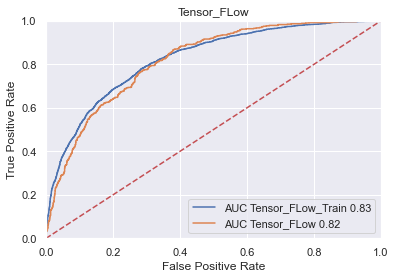

Tensor_FLow CLASSIFICATION ACCURACY
Tensor_FLow_Train  =  0.7962625894915666
Tensor_FLow  =  0.7908782144590005
------


Tensor_FLow RMSE ACCURACY
Tensor_FLow_Train  =  4683.354627982258
Tensor_FLow  =  4696.635652374313
------




In [16]:
WHO = "Tensor_FLow"

U_train = theScaler.transform( X_train )
U_test = theScaler.transform( X_test )

U_train = pd.DataFrame( U_train )
U_test = pd.DataFrame( U_test )

U_train.columns = list( X_train.columns.values )
U_test.columns = list( X_train.columns.values )

#using the variables that the gradient boosting model liked
#could comment out the two lines below so it would use all the variables
U_train = U_train[ GB_flag ]
U_test = U_test[ GB_flag ]

F_theShapeSize = U_train.shape[1]
F_theActivation = tf.keras.activations.relu
F_theLossMetric = tf.keras.losses.SparseCategoricalCrossentropy()
F_theOptimizer = tf.keras.optimizers.Adam()
F_theEpochs = 100

F_theUnits = int( 2*F_theShapeSize / 3 )

F_LAYER_01 = tf.keras.layers.Dense( units=F_theUnits, activation=F_theActivation, input_dim=F_theShapeSize )
F_LAYER_DROP = tf.keras.layers.Dropout( 0.2 )
F_LAYER_02 = tf.keras.layers.Dense( units=F_theUnits, activation=F_theActivation )
F_LAYER_OUTPUT = tf.keras.layers.Dense( units=2, activation=tf.keras.activations.softmax )


CLM = tf.keras.Sequential()
CLM.add( F_LAYER_01 )
CLM.add( F_LAYER_DROP )
CLM.add( F_LAYER_02 )
CLM.add( F_LAYER_OUTPUT )
CLM.compile( loss=F_theLossMetric, optimizer=F_theOptimizer)
CLM.fit( U_train, Y_train[TARGET_F], epochs=F_theEpochs, verbose=False )

TRAIN_CLM = get_TF_ProbAccuracyScores( WHO + "_Train", CLM, U_train, Y_train[ TARGET_F ] )
TEST_CLM = get_TF_ProbAccuracyScores( WHO, CLM, U_test, Y_test[ TARGET_F ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )


V_train = theScaler.transform( W_train )
V_test = theScaler.transform( W_test )

V_train = pd.DataFrame( V_train )
V_test = pd.DataFrame( V_test )

V_train.columns = list( W_train.columns.values )
V_test.columns = list( W_train.columns.values )

#using the variables that the gradient boosting model liked
V_train = V_train[ GB_amt ]
V_test = V_test[ GB_amt ]


A_theShapeSize = V_train.shape[1]
A_theActivation = tf.keras.activations.relu
A_theLossMetric = tf.keras.losses.MeanSquaredError()
A_theOptimizer = tf.keras.optimizers.Adam()
A_theEpochs = 800

A_theUnits = int( 2*A_theShapeSize  )

A_LAYER_01 = tf.keras.layers.Dense( units=A_theUnits, activation=A_theActivation, input_dim=A_theShapeSize )
A_LAYER_DROP = tf.keras.layers.Dropout( 0.2 )
A_LAYER_02 = tf.keras.layers.Dense( units=A_theUnits, activation=A_theActivation )
A_LAYER_OUTPUT = tf.keras.layers.Dense( units=1, activation=tf.keras.activations.linear )

AMT = tf.keras.Sequential()
AMT.add( A_LAYER_01 )
AMT.add( A_LAYER_DROP )
AMT.add( A_LAYER_02 )
AMT.add( A_LAYER_OUTPUT )
AMT.compile( loss=A_theLossMetric, optimizer=A_theOptimizer)
AMT.fit( V_train, Z_train[TARGET_A], epochs=A_theEpochs, verbose=False )


TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, V_train[GB_amt], Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, V_test[GB_amt], Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

TF_CLM = TEST_CLM.copy()
TF_AMT = TEST_AMT.copy()

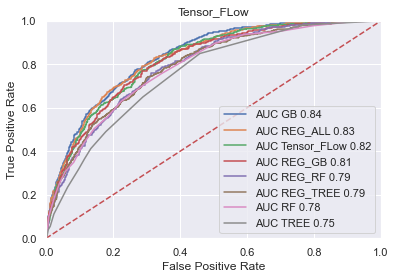

ALL CLASSIFICATION ACCURACY
GB  =  0.7976710334788938
REG_ALL  =  0.7933042212518195
REG_GB  =  0.7913634158175643
Tensor_FLow  =  0.7908782144590005
REG_RF  =  0.779718583212033
REG_TREE  =  0.779718583212033
RF  =  0.772440562833576
TREE  =  0.7535177098495875
------


ALL DAMAGE MODEL ACCURACY
REG_TREE  =  4694.992022985965
REG_GB  =  4696.304119746317
Tensor_FLow  =  4696.635652374313
REG_RF  =  4700.9775519494315
TREE  =  4706.726357721267
REG_ALL  =  4775.747234717834
RF  =  4846.41844014642
GB  =  4862.711161002881
------




In [17]:
ALL_CLM = [ TREE_CLM, RF_CLM, GB_CLM, REG_ALL_CLM, REG_TREE_CLM, REG_RF_CLM, REG_GB_CLM, TF_CLM ]

ALL_CLM = sorted( ALL_CLM, key = lambda x: x[4], reverse=True )
print_ROC_Curve( WHO, ALL_CLM ) 

ALL_CLM = sorted( ALL_CLM, key = lambda x: x[1], reverse=True )
print_Accuracy( "ALL CLASSIFICATION ACCURACY", ALL_CLM )



ALL_AMT = [ TREE_AMT, RF_AMT, GB_AMT, REG_ALL_AMT, REG_TREE_AMT, REG_RF_AMT, REG_GB_AMT, TF_AMT ]
ALL_AMT = sorted( ALL_AMT, key = lambda x: x[1] )
print_Accuracy( "ALL DAMAGE MODEL ACCURACY", ALL_AMT )